In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import gymnasium as gym

from itertools import count
import random

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# DONT RUN THIS CELL ON THE SERVER
# basic loop of gymnasium - how to run  environment 
env = gym.make("Ant-v5", render_mode="human")
env = gym.wrappers.RecordEpisodeStatistics(env)
observation, info = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [228]:
class ReplayMemory:
    """
        Circular buffer for interactions with environment.
    """
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0] for i in indices]
        actions  = [self.buffer[i][1] for i in indices]
        rewards  = [self.buffer[i][2] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [self.buffer[i][4] for i in indices]
        return states, actions, rewards, n_states, dones

    def __len__(self):
        return len(self.buffer)

memory = ReplayMemory(buffer_size=100_000) # default length of episode is 50, so it should fit around 50 episodes. 

In [229]:
class QNet(torch.nn.Module):
    """
        It takes observation-action pair and outputs Q-value for it.
    """
    def __init__(self, actions_space_size: int = 1, observation_stapce_size:int = 4, hidden_size: int=64):
        # defaults set for MuJuCo ant
        super(QNet, self).__init__()

        self.action_space_size = actions_space_size
        self.observation_space_size = observation_stapce_size
        self.hidden_size = hidden_size 
        
        self.net = nn.Sequential(
            nn.Linear(self.observation_space_size + self.action_space_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size * 4),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size * 4, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
        )
        # we don't apply activation as we want Q value as an ouput

    def forward(self, x):
        # x should be observations and actions concatenated into one vector x
        q = self.net(x)
        return q
    
    
class PolicyNet(nn.Module):
    """
        It takes state as an input and outputs the best action
    """
    def __init__(self, action_space_size: int = 1, observation_stapce_size:int = 4, hidden_size: int=64):
        super().__init__()

        self.action_space_size = action_space_size
        self.observation_space_size = observation_stapce_size
        self.hidden_size = hidden_size 
        
        self.net = nn.Sequential(
            nn.Linear(self.observation_space_size, self.hidden_size),
            nn.Tanh(),
            nn.Linear(self.hidden_size, self.hidden_size * 4),
            nn.Tanh(),
            # nn.Linear(self.hidden_size * 4, self.hidden_size),
            # nn.Tanh(),
            nn.Linear(self.hidden_size * 4, self.action_space_size),
            nn.Tanh()
        )
        # apparently Tanh works better as activation function in agent networks

    def forward(self, s):
        a = self.net(s)
        return a

q_origin_model = QNet().to(device)  # Q_phi
q_target_model = QNet().to(device)  # Q_phi'
_ = q_target_model.requires_grad_(False)  # target model doen't need grad

mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

In [230]:
from functools import reduce


gamma = 0.99
opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=0.005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.005)


def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device).squeeze(-1)
    dones = torch.tensor(dones, dtype=torch.float).to(device).unsqueeze(1)

    criterion = nn.MSELoss(reduction="mean").to(device)
    # Optimize critic loss
    opt_q.zero_grad()
    q_org = q_origin_model(torch.concat((states, actions.unsqueeze(-1)), dim=1))
    mu_tgt_next = mu_target_model(next_states)
    q_tgt_next = q_target_model(torch.concat((next_states, mu_tgt_next), dim=1))
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next
    loss_q = criterion(q_org, q_tgt)
    loss_q.backward()
    # print("q org", sum(map(lambda x: x.weight.grad.abs().mean() if hasattr(x, 'weight') else 0, q_origin_model.net)))
    opt_q.step()

    # Optimize actor loss
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    for p in q_origin_model.parameters():
        p.requires_grad = False  # disable grad in q_origin_model before computation
    q_tgt_max = q_origin_model(torch.concat((states, mu_org), dim=1))
    loss_mu = -q_tgt_max.mean()
    loss_mu.backward()
    # print(mu_org.mean())
    # print("mu org", sum(map(lambda x: x.weight.grad.abs().mean() if hasattr(x, 'weight') else 0, mu_origin_model.net)))
    opt_mu.step()
    for p in q_origin_model.parameters():
        p.requires_grad = True  # enable grad again

In [231]:
tau = 0.005

def update_target():
    for var, var_target in zip(q_origin_model.parameters(), q_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

In [232]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s):
    with torch.no_grad():
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(dim=0)
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        action = np.clip(action, -1.0, 1.0)
        # return action
        return action[0]

In [233]:
batch_size = 250
# env = gym.make("Ant-v5", render_mode=None) # we don't need to render during training
# env = gym.wrappers.RecordEpisodeStatistics(env)

from cartpole import CartPole
env = CartPole()

reward_records = []
cum_step = 0
for i in range(2000):
    # Run episode till done
    state, _ = env.reset()
    done = False
    cum_reward = 0
    while not done:
        if len(memory) >= batch_size * 30:
            action = pick_sample(state)
        else:
            action = np.random.random(1)[0] * 2 - 1
        state_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.add([state, action, reward, state_next, float(done)])
        cum_reward += reward

        s = state_next
        cum_step += 1

        # Train (optimize parameters)
        if len(memory) >= batch_size * 30:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)
            optimize(states, actions, rewards, next_states, dones)
            update_target()

    print(f"Run episode {i} with rewards {cum_reward}, total step: {cum_step}", end="\n")
    reward_records.append(cum_reward)

    # early stop if we get good results
    if np.average(reward_records[-10:]) > 450:
        break

print("\nDone")

Run episode 0 with rewards 17.0, total step: 17
Run episode 1 with rewards 20.0, total step: 37
Run episode 2 with rewards 29.0, total step: 66
Run episode 3 with rewards 20.0, total step: 86
Run episode 4 with rewards 19.0, total step: 105
Run episode 5 with rewards 17.0, total step: 122
Run episode 6 with rewards 21.0, total step: 143
Run episode 7 with rewards 20.0, total step: 163
Run episode 8 with rewards 17.0, total step: 180
Run episode 9 with rewards 17.0, total step: 197
Run episode 10 with rewards 20.0, total step: 217
Run episode 11 with rewards 20.0, total step: 237
Run episode 12 with rewards 29.0, total step: 266
Run episode 13 with rewards 14.0, total step: 280
Run episode 14 with rewards 26.0, total step: 306
Run episode 15 with rewards 34.0, total step: 340
Run episode 16 with rewards 27.0, total step: 367
Run episode 17 with rewards 25.0, total step: 392
Run episode 18 with rewards 26.0, total step: 418
Run episode 19 with rewards 20.0, total step: 438
Run episode 20

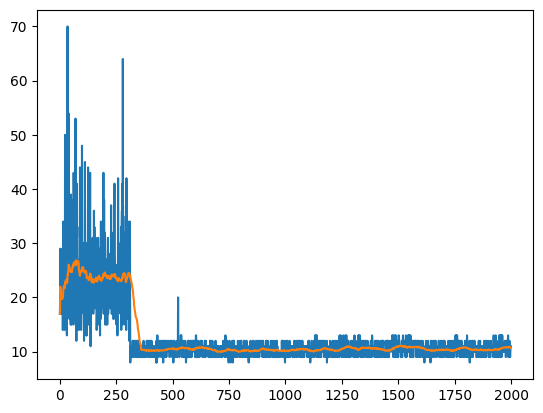

In [234]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

### Down there, there is boilerplate for later

In [ ]:
class Agent:
    """
    This is going to represent
    """

    def __init__(
        self,
        learning_rate: float,
        batch_size: int,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """
        Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.dqn = DQN().to(device)
        self.target_dqn = DQN().to(device)
        self.target_dqn.load_state_dict(self.dqn.state_dict())

        self.optimizer = optim.AdamW(
            self.dqn.parameters(), lr=learning_rate, amsgrad=True
        )
        self.memory = ReplayMemory(10000)

        self.lr = learning_rate
        self.batch_size = batch_size
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, state: np.ndarray) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return torch.tensor(
                [env.action_space.sample()], device=device, dtype=torch.float32
            )

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.dqn(state)

    def optimize_model(self):
        """Updates the model"""

        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=device,
            dtype=torch.bool,
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.dqn(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = (
                self.target_dqn(non_final_next_states).max(1).values
            )
        # Compute the expected Q values
        expected_state_action_values = (
            next_state_values * self.discount_factor
        ) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.dqn.parameters(), 100)
        self.optimizer.step()

        # save for plotting later on
        self.training_error.append(loss.item())

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def update_target_model(self):
        self.target_dqn.load_state_dict(self.dqn.state_dict())

In [ ]:
# hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPISODES = 100
START_EPSILON = 1.0
EPSILON_DECAY = START_EPSILON / (N_EPISODES / 2)  # reduce the exploration over time
FINAL_EPSILON = 0.1

UPDATE_TARGET_EVERY = 10

agent = Agent(
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    initial_epsilon=START_EPSILON,
    epsilon_decay=EPSILON_DECAY,
    final_epsilon=FINAL_EPSILON,
)

In [ ]:

for i_episode in tqdm(range(N_EPISODES)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # fancy itertools for counting
    for t in count():
        action = agent.get_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.squeeze(0).cpu().numpy())
        reward = torch.tensor([reward], device=device)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.optimize_model()

        if i_episode % UPDATE_TARGET_EVERY == 0:
            agent.update_target_model()

        if terminated or truncated:
            agent.decay_epsilon()
            break

In [ ]:
rolling_length = N_EPISODES // 100
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()